<a href="https://colab.research.google.com/github/hchaparov/Dynamic_Pricing_MARL/blob/main/SA_Pong_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install ffmpeg
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 41.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
env_id = "PongNoFrameskip-v4"
n_training_envs = 8

# Create log dir where evaluation results will be saved
eval_log_dir = "/content/drive/My Drive/SA_pong_ppo/"
os.makedirs(eval_log_dir, exist_ok=True)


In [4]:
# Initialize a vectorized training environment with default parameters
train_env = make_atari_env(env_id, n_envs=n_training_envs, seed=0)

In [5]:
temp_eval_log_dir = "/content/drive/My Drive/SA_pong_ppo/tmp"
os.makedirs(temp_eval_log_dir, exist_ok=True)

# Create callback that evaluates agent for 500 episodes every 5000 training environment steps.
eval_callback = EvalCallback(train_env, best_model_save_path=temp_eval_log_dir,
                             log_path=temp_eval_log_dir, eval_freq=max(5000 // n_training_envs, 1),
                             n_eval_episodes=500, deterministic=True,
                             render=False)

In [6]:
# Load existing model or create a new one
model_path = '/content/drive/My Drive/SA_pong_ppo/SA_pong_ppo_250k'
if os.path.exists(model_path + '.zip'):
    model = PPO.load(model_path, env=train_env)
else:
    model = PPO("CnnPolicy", train_env, verbose=1)


Wrapping the env in a VecTransposeImage.


In [15]:
model.learn(total_timesteps=75000, callback=eval_callback)
model.save("/content/drive/MyDrive/SA_pong_ppo/SA_pong_ppo_250k")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7e4d312cdde0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7e4e935976a0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=5000, episode_reward=2.02 +/- 11.78
Episode length: 11761.41 +/- 2653.35
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.18e+04 |
|    mean_reward     | 2.02     |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------
New best mean reward!
Eval num_timesteps=10000, episode_reward=2.52 +/- 11.44
Episode length: 11732.91 +/- 2572.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.17e+04 |
|    mean_reward     | 2.52     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
New best mean reward!
Eval num_timesteps=15000, episode_reward=1.33 +/- 11.57
Episode length: 11906.43 +/- 2558.75
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.19e+04 |
|    mean_reward     | 1.33     |
| time/              |          |
|    total_timesteps | 15000    

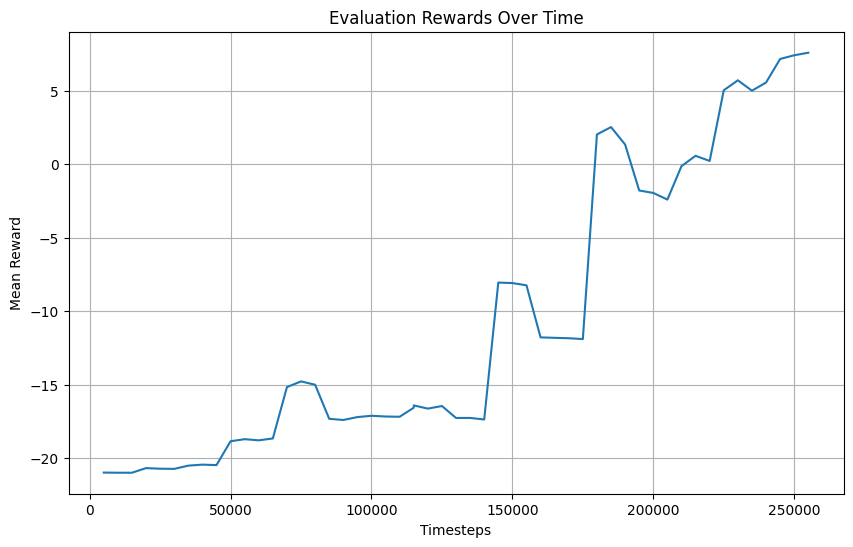

In [7]:
# Load existing evaluation results if they exist
results_file = os.path.join(eval_log_dir, 'evaluations.npz')
if os.path.exists(results_file):
    old_results = np.load(results_file)
    old_timesteps = old_results['timesteps']
    old_results_raw = old_results['results']
else:
    old_timesteps = np.array([])
    old_results_raw = np.array([]).reshape(0, 5)

# Load new evaluation results
new_results_file = os.path.join(temp_eval_log_dir, 'evaluations.npz')
new_results = np.load(new_results_file)
new_timesteps = new_results['timesteps']
new_results_raw = new_results['results']

# Append new results to old results
if old_timesteps.size > 0:
    combined_timesteps = np.concatenate((old_timesteps, new_timesteps + old_timesteps[-1]))
    combined_results_raw = np.concatenate((old_results_raw, new_results_raw))
else:
    combined_timesteps = new_timesteps
    combined_results_raw = new_results_raw

# Save combined results
np.savez(results_file, timesteps=combined_timesteps, results=combined_results_raw)

# Calculate the mean reward for each evaluation point
combined_results_mean = combined_results_raw.mean(axis=1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(combined_timesteps, combined_results_mean)
plt.xlabel('Timesteps')
plt.ylabel('Mean Reward')
plt.title('Evaluation Rewards Over Time')
plt.grid()
plt.show()

In [9]:
video_folder = "logs/videos/"
video_length = 1000# Record the video

env = VecVideoRecorder(train_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"trained-agent-{env_id}")

# Reset the environment
obs = env.reset()

# Run the environment for the specified number of steps using the trained model
for _ in range(video_length + 1):
    action, _ = model.predict(obs)  # Predict the action using the trained model
    obs, _, _, _ = env.step(action)  # Take the action in the environment

# Close the VecVideoRecorder and save the video
env.close()

# Function to display the video
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width="480" height="320" controls><source src="{data_url}" type="video/mp4"></video>')

# Display the video
show_video(video_folder + f"trained-agent-{env_id}-step-0-to-step-{video_length}.mp4")

Saving video to /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4
Moviepy - Building video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4


In [14]:
# Clean up temporary evaluation logs
import shutil
shutil.rmtree(temp_eval_log_dir)